In [3]:
from google.colab import drive
drive.mount('./drive')

Mounted at ./drive


In [ ]:
import nltk
nltk.download('punkt')
import tensorflow as tf
from nltk.tokenize import word_tokenize

import re
import pandas as pd
import numpy as np
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Layer
import keras.backend as K
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [6]:
data = pd.read_csv('/content/drive/MyDrive/Sc_3/Dataset 3.csv', encoding = "unicode_escape")
train, test = train_test_split( data, test_size=0.2, random_state=20 )

In [7]:
data.head(10)

,tweets,sentiment
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
5,so sleepy. good times tonight though,0
6,"@SilkCharm re: #nbn as someone already said, d...",0
7,23 or 24Ã¯Â¿Â½C possible today. Nice,0
8,nite twitterville workout in the am -ciao,0
9,"@daNanner Night, darlin'! Sweet dreams to you",0


**Observing the dataset**

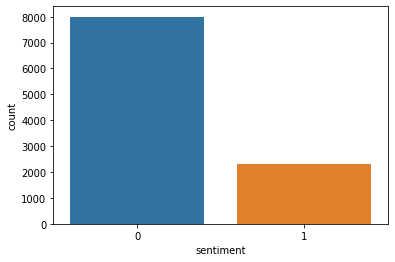

In [8]:
sns.countplot(x="sentiment", data=data)

**Preprocessing**

In [11]:
def preprocess(tweet):
  pattern = re.compile( r'(www|http|https)[-%+:/_.=?&\w]*' ) #removing links
  pattern2 = re.compile( r'(#\w+|\w+)\.(\w+)[-%+:/_.=?&\w]*' ) #removing hashtags
  pattern3 = re.compile( r'[^A-Za-z0-9 ]+' ) #removing anything that is not within A-Z, a-z, 0-9 and a single space
  pattern4 = re.compile( r'\b[Aa]{1,}[rR]{1,}[gGhH]{3,}\b') #removing words such as Arrrggh Arrrggggh etc
  pattern5 = re.compile( r'[0-9]+' ) #removing pure numbers
  pattern6 = re.compile( r'\b[Aa]{1,}[hH]{2,}\b' ) #removing words such as Aaaaah
  pattern7 = re.compile(r'\b[gG]{1,}[rR]{3,}\b') #removing words such as grrrrr
  pattern8 = re.compile(r'\b[uU]+[gG]+[hH]+\b') #removings words such as urgggh

  pattern9 = re.compile( r'(\bh{3,}\b|\Bh{3,}\B|\bh{3,}\b|\bh{3,}\B|\Bh{3,}\b)' ) #removing extra h as in arghhhhhhh
  pattern10 = re.compile( r'(\bo{3,}\b|\Bo{3,}\B|\bo{3,}\b|\bo{3,}\B|\Bo{3,}\b)' ) #removing extra o as in boooook

  pattern11 = re.compile( r'\bgr8\b' ) #removing gr8 and replacing with great
  pattern12 = re.compile( r'\bgd\b' ) #removing gd to good
  pattern13 = re.compile( r'\b[oO]+[mM]+[fF]*[gG]+\b' ) #removing omg to oh my god
  pattern14 = re.compile( r'\b(lol|lmao)\b' ) #removing lol, lmao to laughing
  pattern15 = re.compile( r'(\ba{3,}\b|\Ba{3,}\B|\ba{3,}\b|\ba{3,}\B|\Ba{3,}\b)' ) #removing extra a as in haaaappy
  pattern16 = re.compile( r'(\w)\1{3,}' )
  pattern17 = re.compile( r'\b(?:haha)+[ah]*\b' ) #convering all  types hahaha, hahaha hahah to laughing
  pattern18 = re.compile( r'\b(thx|thanx|tq)\b' ) #converting all types of saying thanks to thanks

  for i in range( tweet.shape[0] ):
    pat = re.sub( pattern,'',tweet[i].lower() )
    pat = re.sub( pattern2,'',pat )
    pat = re.sub( pattern3,'',pat )
    pat = re.sub( pattern4,'', pat )
    pat = re.sub( pattern11, 'great', pat )
    pat = re.sub( pattern5, '', pat )
    pat = re.sub( pattern6, '', pat )
    pat = re.sub( pattern7, '', pat )
    pat = re.sub( pattern8, '', pat )
    pat = re.sub( pattern9, 'h', pat )
    pat = re.sub( pattern10, 'o', pat )
    pat = re.sub( pattern12, 'good', pat )
    pat = re.sub( pattern13, 'Oh my God', pat )
    pat = re.sub( pattern14, 'laughing', pat )
    pat = re.sub( pattern15, 'a', pat )
    pat = re.sub( pattern16, r'\1', pat )
    pat = re.sub( pattern17, 'laughing', pat )
    pat = re.sub( pattern18, 'thanks', pat )
    pat = ' '.join( pat.split() )
    tweet[i] = pat
  return tweet

In [12]:
tweet = preprocess( tweet = pd.concat( ( train['tweets'], test['tweets'] ), axis = 0, ignore_index = True ) )

In [13]:
tweet.shape

(10314,)

**Tokenization**

In [14]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(tweet)
vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

21052

In [15]:
embedded_sentences = word_tokenizer.texts_to_sequences(tweet)
print(embedded_sentences)

[[4116, 6274, 2619, 205, 5, 87, 388, 300, 235, 452, 4117, 22, 5, 1, 337, 1730, 733], [6275, 1, 949, 6, 15, 29, 49, 23, 4, 608, 33], [1312, 3, 377, 10, 950, 12, 30, 524, 795, 566, 507, 5, 40, 25, 6276, 1, 19, 3, 136, 189, 1430], [6277, 227, 687, 152, 456, 6278, 63, 103, 434, 6279, 6280, 6281], [6282, 3144, 19, 6, 4118, 4119, 1226, 62, 4, 3145, 64, 5, 64, 4119, 856, 19, 7, 5, 55, 62, 525], [6283, 73, 901, 26, 15, 10, 27, 70], [20, 314, 6284, 314, 6285, 3, 632, 13, 4, 526, 357, 1313, 2620, 6286, 18, 137, 190, 27, 1139, 3146, 6287], [1314, 37, 734, 11, 7], [155, 4, 902, 1315, 951, 441], [218, 9, 280, 41, 8, 7, 5, 8, 952, 1063, 94, 4, 114, 255, 278, 272, 18, 78, 26, 63, 103, 6288, 1937, 88, 72, 16, 6, 609, 194, 185, 7, 10, 75, 413, 1, 43, 159, 1, 104, 133, 633, 8, 72, 16, 303, 111, 550, 442, 358], [6289, 735, 903, 9, 7, 736, 1, 96, 6, 28, 3147, 147], [6290, 1, 131, 12, 11, 6, 857], [6291, 3, 59, 1, 66, 53, 11, 4, 1731, 13, 3, 250, 12, 49, 23, 127, 57, 5, 3, 278, 2244, 118, 76, 950, 49, 44],

In [16]:
word_count = lambda sentence: len(word_tokenize(sentence))
longest_sentence = max(tweet, key=word_count)
length_long_sentence = len(word_tokenize(longest_sentence))
padded_sentences = pad_sequences(embedded_sentences, length_long_sentence, padding='post')
print(padded_sentences)

[[ 4116  6274  2619 ...     0     0     0]
 [ 6275     1   949 ...     0     0     0]
 [ 1312     3   377 ...     0     0     0]
 ...
 [  130  1851 21048 ...     0     0     0]
 [21049    50    69 ...     0     0     0]
 [    7    10     3 ...     0     0     0]]


**Glove Embedding Initialization**

In [18]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/drive/My Drive/Sc_3/glove.6B.100d.txt', encoding="utf8")

In [19]:
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [20]:
embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

**Padding**

In [21]:
train_padded_sentences = padded_sentences[0: train.shape[0]]
test_padded_sentences = padded_sentences[train.shape[0]:]
train_sentiment = train['sentiment']
test_sentiment = test['sentiment']

**Model Setup and Training**

In [22]:
inputs=Input((length_long_sentence,))

x = Embedding(input_dim = vocab_length,output_dim=100, weights=[embedding_matrix], input_length=length_long_sentence, trainable=False )(inputs)
l1 = LSTM(100,return_sequences=True,dropout=0.2,recurrent_dropout=0.2)(x)
l2 = LSTM(100,return_sequences=True,dropout=0.8,recurrent_dropout=0.8)(l1)
l3 = LSTM(100,dropout=0.2,recurrent_dropout=0.2)(l2)

outputs=Dense(1,activation='sigmoid',trainable=True)(l3)
model=Model(inputs,outputs)
#model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(x=train_padded_sentences,y=train_sentiment,batch_size=64,epochs=20,verbose=1,shuffle=False, validation_split=0.2, validation_data=train_padded_sentences)

Epoch 1/20
104/104 [==============================] - 68s 577ms/step - loss: 0.2362 - acc: 0.9167 - val_loss: 0.0911 - val_acc: 0.9758
Epoch 2/20
104/104 [==============================] - 59s 570ms/step - loss: 0.0691 - acc: 0.9833 - val_loss: 0.0641 - val_acc: 0.9873
Epoch 3/20
104/104 [==============================] - 59s 569ms/step - loss: 0.0544 - acc: 0.9885 - val_loss: 0.0590 - val_acc: 0.9849
Epoch 4/20
104/104 [==============================] - 59s 567ms/step - loss: 0.0546 - acc: 0.9882 - val_loss: 0.0512 - val_acc: 0.9897
Epoch 5/20
104/104 [==============================] - 59s 566ms/step - loss: 0.0507 - acc: 0.9897 - val_loss: 0.0439 - val_acc: 0.9903
Epoch 6/20
104/104 [==============================] - 59s 567ms/step - loss: 0.0459 - acc: 0.9911 - val_loss: 0.0468 - val_acc: 0.9897
Epoch 7/20
104/104 [==============================] - 59s 568ms/step - loss: 0.0427 - acc: 0.9914 - val_loss: 0.0461 - val_acc: 0.9903
Epoch 8/20
104/104 [==============================] - 5

**Evaluation**

In [23]:
result = model.predict(test_padded_sentences)

In [24]:
result[ result < 0.5 ] = 0
result[ result >= 0.5] = 1

In [25]:
def evaluate(rTrue, rPred):
  print('Accuracy : ', accuracy_score(rTrue, rPred))
  print('Recall   : ', recall_score(rTrue, rPred, average=None))
  print('Precision: ', precision_score(rTrue, rPred, average=None))
  print('F1 Score : ', f1_score(rTrue, rPred, average=None))

In [26]:
evaluate(test_sentiment, result)

Accuracy :  0.9927290353853612
Recall   :  [1.         0.96681416]
Precision:  [0.99077491 1.        ]
F1 Score :  [0.99536608 0.98312711]


In [27]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_sentiment, result)

array([[1611,    0],
       [  15,  437]])

**Graphs**

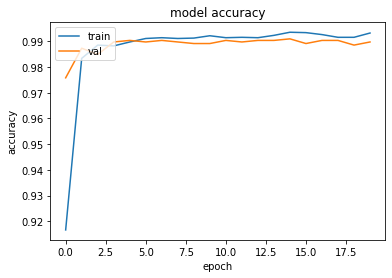

In [29]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

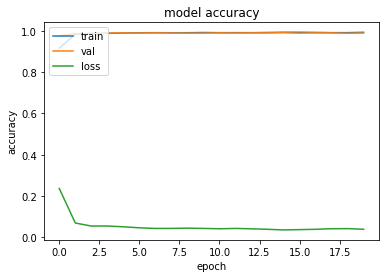

In [30]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val','loss'], loc='upper left')
plt.show()

**Predictions**

In [31]:
def predict(data):
  test_data = preprocess(np.array([data]))
  test_data_embedded = word_tokenizer.texts_to_sequences(test_data)
  padded_test_data = pad_sequences(test_data_embedded, length_long_sentence, padding='post')
  test_result = model.predict( padded_test_data )
  print('Result: ',end=' ')
  if test_result[0][0] >= 0.5:
    print(1)
  else:
    print(0)

In [32]:
predict('Depression is killing me from inside. Help!')

Result:  1


In [33]:
predict('Such a lovely day!')

Result:  0


In [34]:
predict('I will kill myself out of anxiety.')

Result:  1
